In [38]:
import numpy as np

class ATSPInstance:
    def __init__(self, filename):
        self.name = ""
        self.dimension = 0
        self.distance_matrix = None
        self.parse_instance(filename)

    def parse_instance(self, filename):
        edge_weights = []
        reading_edge_weights = False

        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()

                if "NAME:" in line:
                    self.name = line.split()[1]
                elif "DIMENSION:" in line:
                    self.dimension = int(line.split()[1])
                elif line == "EDGE_WEIGHT_SECTION":
                    reading_edge_weights = True
                elif reading_edge_weights:
                    if line == "EOF":
                        break
                    edge_weights.extend(map(int, line.split()))

        self.distance_matrix = np.array(edge_weights).reshape((self.dimension, self.dimension))

    def print_instance(self):
        print(f"ATSP Instance: {self.name}")
        print(f"Dimension: {self.dimension}")
        print("Distance Matrix:")
        print(self.distance_matrix)



In [39]:
import gurobipy as gp
from gurobipy import GRB

def solve_atsp(instance):
    try:
        # Assume que instance.dimension e instance.distance_matrix estão disponíveis
        n = instance.dimension
        dist = instance.distance_matrix

        # Cria o ambiente e o modelo
        model = gp.Model("ATSP")

        # Cria as variáveis x[i][j] binárias
        x = [[model.addVar(vtype=GRB.BINARY, obj=dist[i][j]) if i != j else None for j in range(n)] for i in range(n)]

        # Cria as variáveis contínuas u[i] para a formulação MTZ
        u = [model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY) for i in range(n)]

        # Define o sentido de minimização no modelo
        model.modelSense = GRB.MINIMIZE

        # Restrições de grau: Cada cidade deve ter exatamente um arco de entrada e um de saída
        for i in range(n):
            model.addConstr(gp.quicksum(x[i][j] for j in range(n) if i != j) == 1, name=f"out_{i}")
            model.addConstr(gp.quicksum(x[j][i] for j in range(n) if i != j) == 1, name=f"in_{i}")

        # Restrições MTZ para eliminação de subciclos
        for i in range(1, n):
            for j in range(1, n):
                if i != j:
                    model.addConstr(u[i] - u[j] + (n - 1) * x[i][j] <= n - 2)

        # Restrições de limites para u[i]
        for i in range(1, n):
            model.addConstr(u[i] >= 1)
            model.addConstr(u[i] <= n - 1)

        # Fixar u[0] a 0
        model.addConstr(u[0] == 0)

        # Otimizar o modelo
        model.optimize()

        # Verificar se uma solução ótima foi encontrada
        if model.status == GRB.OPTIMAL:
            print(f"Comprimento ótimo da rota: {model.objVal}")
            print("Rota ótima:")

            # Imprimir a rota a partir do vértice 0
            current_vertex = 0
            visited = [False] * n
            for count in range(n):
                visited[current_vertex] = True
                for j in range(n):
                    if current_vertex != j and x[current_vertex][j].x > 0.5:
                        print(f"{current_vertex} -> {j}", end=" ")
                        current_vertex = j
                        break
            print()

            # Retorna a solução na forma de uma matriz 2D
            solution = [[x[i][j].x if i != j else None for j in range(n)] for i in range(n)]
            return solution
        else:
            print("Nenhuma solução ótima encontrada.")


    except gp.GurobiError as e:
        print(f"Erro no Gurobi: {e.errno}, {e.message}")
    except Exception as e:
        print(f"Erro durante a otimização: {e}")



In [40]:
x = solve_atsp(instancia)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 307 rows, 289 columns and 1297 nonzeros
Model fingerprint: 0xf9c39470
Variable types: 17 continuous, 272 integer (272 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 33 rows and 1 columns
Presolve time: 0.00s
Presolved: 274 rows, 288 columns, 2538 nonzeros
Variable types: 16 continuous, 272 integer (272 binary)
Found heuristic solution: objective 151.0000000

Root relaxation: objective 2.350000e+00, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

In [41]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_atsp_solution(instance, x):
    """
    Plota a rota ótima da solução do ATSP como um grafo.

    :param instance: Instância do problema ATSP, contendo a matriz de distâncias.
    :param x: Matriz de variáveis de decisão da solução do Gurobi.
    """

    # Cria um grafo vazio
    G = nx.DiGraph()

    # Adiciona os nós ao grafo (cidades)
    n = instance.dimension
    G.add_nodes_from(range(n))

    # Adiciona as arestas da solução ótima
    for i in range(n):
        for j in range(n):
            if i != j and x[i][j] > 0.5:
                G.add_edge(i, j, weight=instance.distance_matrix[i][j])

    # Definir a posição dos nós em um círculo para visualização
    pos = nx.circular_layout(G)

    # Desenhar o grafo
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500, font_size=10, font_weight="bold", arrows=True)

    # Desenhar as arestas com as distâncias
    edge_labels = {(i, j): f"{instance.distance_matrix[i][j]}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Solução Ótima do ATSP")
    plt.show()



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 307 rows, 289 columns and 1297 nonzeros
Model fingerprint: 0xf9c39470
Variable types: 17 continuous, 272 integer (272 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 33 rows and 1 columns
Presolve time: 0.00s
Presolved: 274 rows, 288 columns, 2538 nonzeros
Variable types: 16 continuous, 272 integer (272 binary)
Found heuristic solution: objective 151.0000000

Root relaxation: objective 2.350000e+00, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

     0     0   18.26786    0   27   42.00000   18.26786  56.5%     -    0s
H    0     0                      39.0000000   18.26786  53.2%     -    0s
     0     0   28.00000    0   29   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   29   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   33   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   33   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   10   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   10   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0    8   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   16   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   10   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0   17   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000    0    8   39.00000   28.00000  28.2%     -    0s
     0     0   28.00000  

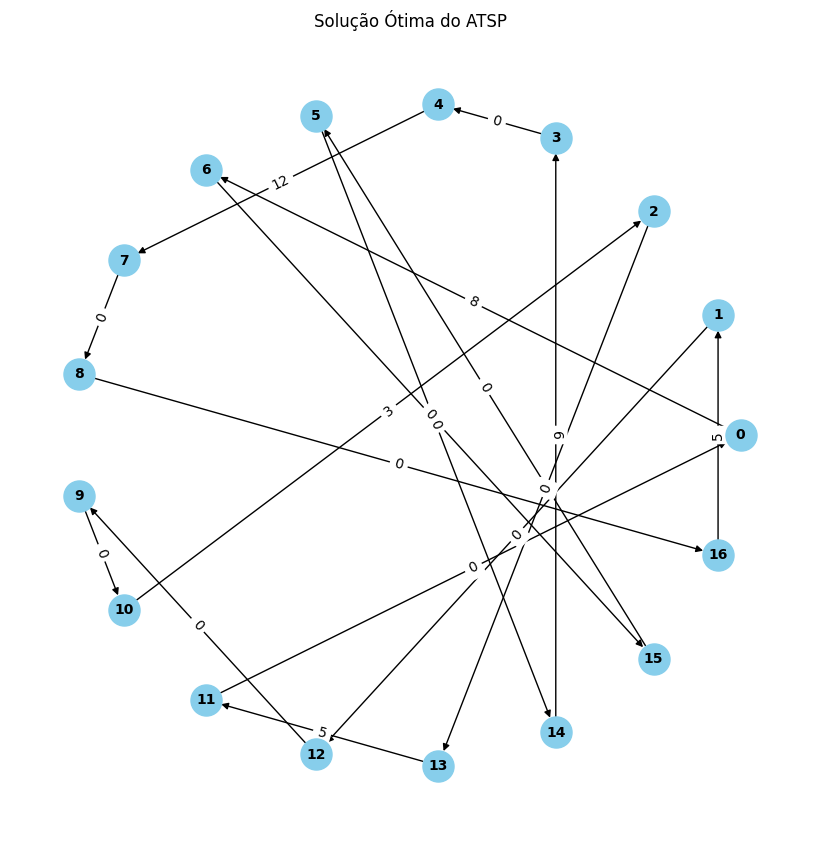

In [42]:
instancia = ATSPInstance("br17.atsp")
#instancia.print_instance()
x = solve_atsp(instancia)
plot_atsp_solution(instancia, x)